# Import Librarys

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import torch.nn.init as init
import torch.nn.functional as F


In [41]:
!nvidia-smi

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Sat Feb  8 12:08:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.51.01              Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050        On  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              4W /   30W |     121MiB /   4096MiB |      0%      Default |
|                                         |                       

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

# Load Dataset

Data Parameters

In [43]:
L_valid = 2000
L_train = 15000
T_exploration = 100 # 50 / 220
N = 5 # 5 / 20 / 80
N0 = 0.001

file_x_valid_pre = 'Numpy_array_save/N=5_wireless_poly(Rlink=0.3)/x_valid_pre.npy'
file_x_valid = 'Numpy_array_save/N=5_wireless_poly(Rlink=0.3)/x_valid.npy'
file_y_valid = 'Numpy_array_save/N=5_wireless_poly(Rlink=0.3)/y_valid.npy'
file_x_train_pre = 'Numpy_array_save/N=5_wireless_poly(Rlink=0.3)/x_train_pre.npy'
file_x_train = 'Numpy_array_save/N=5_wireless_poly(Rlink=0.3)/x_train.npy'
file_y_train = 'Numpy_array_save/N=5_wireless_poly(Rlink=0.3)/y_train.npy'

Load data

In [44]:
x_train = np.load(file_x_train)
y_train = np.load(file_y_train)
x_valid = np.load(file_x_valid)
y_valid = np.load(file_y_valid)
x_train_pre = np.load(file_x_train_pre)
x_valid_pre = np.load(file_x_valid_pre)

print(f"x_train.shape = {x_train_pre.shape}. x_train.shape = {x_train.shape}, y_train.shape = {y_train.shape}")

x_train.shape = (75000, 200). x_train.shape = (75000, 200), y_train.shape = (75000, 100)


In [84]:
x_train[99, 0:200]

array([0.50305666, 0.01080813, 0.49747159, 0.01572526, 0.49524652,
       0.01619985, 0.49366944, 0.01657383, 0.49253409, 0.01688396,
       0.49172681, 0.01714753, 0.49117354, 0.0173748 , 0.49082158,
       0.01757262, 0.49063139, 0.01774587, 0.49057214, 0.01789821,
       0.49061918, 0.01803249, 0.49075237, 0.01815096, 0.49095501,
       0.01825546, 0.49121307, 0.01834752, 0.49151464, 0.01842841,
       0.49184954, 0.01849923, 0.49220902, 0.0185609 , 0.49258547,
       0.01861426, 0.49297232, 0.01866   , 0.49336382, 0.01869877,
       0.49375494, 0.01873114, 0.49414129, 0.0187576 , 0.49451903,
       0.01877862, 0.49488478, 0.01879462, 0.49523559, 0.01880597,
       0.4955689 , 0.01881303, 0.49588247, 0.01881612, 0.49617436,
       0.01881555, 0.4964429 , 0.01881159, 0.49668668, 0.01880451,
       0.49690449, 0.01879456, 0.49709535, 0.01878197, 0.49725846,
       0.01876696, 0.49739317, 0.01874974, 0.49749903, 0.01873052,
       0.49757571, 0.01870947, 0.49762302, 0.0186868 , 0.49764

Convert to Tensor

In [45]:
x_train_pre = torch.tensor(x_train_pre, dtype=torch.float32)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_valid_pre = torch.tensor(x_valid_pre, dtype=torch.float32)
x_valid = torch.tensor(x_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

# Define NN

In [46]:
class Wireless_poly(nn.Module):
    def __init__(self, input_size, output_size):
        """
        :param input_size: In general (2 * T_exploration) because [(Pn, In)_t=0, ...., (Pn, In)_t=T_explor]
        :param output_size: (2, ) because beta_n and alpha_n
        """
        super(Wireless_poly, self).__init__()
        self.fc0 = nn.Linear(input_size, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)

        # Initialize weights
        self.init_weights()

    def forward(self, x):
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


# Network Train Parameters

In [47]:
input_size = 2 * T_exploration
output_size = 1 # Size of output alpha_n beta_n
model = Wireless_poly(input_size, output_size).to(device=device)

In [48]:
num_epochs = 30
batch_size = 256
lr = 0.0008

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Crate Data Loader for training
train_dataset = TensorDataset(x_train_pre, x_train, y_train)
val_dataset = TensorDataset(x_valid_pre, x_valid, y_valid)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Continue train (Optional)

In [37]:
num_epochs = 2
lr = 0.0008

# Train loop

In [49]:
train_list = []
valid_list = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs_pre, inputs, targets in train_loader:
        # Extract Input and load to GPU
        inputs_pre, inputs, targets = inputs_pre.to(device), inputs.to(device), targets.to(device)
        # Zero Grad
        optimizer.zero_grad()
        # Forward Propagation
        outputs = model(inputs_pre)
        # Extract Parameters
        Pn = inputs[:, ::2]  # Even indices
        In = inputs[:, 1::2]  # Odd indices
        alpha, beta = outputs[:, 0].view(-1, 1), outputs[:, 1].view(-1, 1)
        predicted_prior = alpha * Pn + beta * In
        # predicted_prior = outputs * Pn
        # Calculate loss
        loss = criterion(predicted_prior, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    scheduler.step()  # Update the learning rate

    # Validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs_pre, inputs, targets in val_loader:
            # Extract input and load to GPU
            inputs_pre, inputs, targets = inputs_pre.to(device), inputs.to(device), targets.to(device)
            # Forward Propagation
            outputs = model(inputs_pre)
            # Extract Parameters
            Pn = inputs[:, ::2]  # Even indices
            In = inputs[:, 1::2]  # Odd indices
            alpha, beta = outputs[:, 0].view(-1, 1), outputs[:, 1].view(-1, 1)
            predicted_prior = alpha * Pn + beta * In
            # predicted_prior = outputs * Pn
            # Calculate loss
            loss = criterion(predicted_prior, targets)
            val_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_list.append(train_loss)
    valid_list.append(val_loss)
    lr_value = optimizer.param_groups[0]["lr"]
    print(f"Epoch [{epoch+1}/{num_epochs}] Learning Rate:{lr_value} - "
          f"Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

Epoch [1/30] Learning Rate:0.0008 - Train Loss: 3.84938, Val Loss: 3.40530
Epoch [2/30] Learning Rate:0.0008 - Train Loss: 3.81456, Val Loss: 3.39199
Epoch [3/30] Learning Rate:0.0008 - Train Loss: 3.80586, Val Loss: 3.39112
Epoch [4/30] Learning Rate:0.0008 - Train Loss: 3.80239, Val Loss: 3.38744
Epoch [5/30] Learning Rate:0.0008 - Train Loss: 3.79948, Val Loss: 3.38586
Epoch [6/30] Learning Rate:0.0008 - Train Loss: 3.79755, Val Loss: 3.38444
Epoch [7/30] Learning Rate:0.0008 - Train Loss: 3.79675, Val Loss: 3.38375
Epoch [8/30] Learning Rate:0.0008 - Train Loss: 3.79471, Val Loss: 3.38319
Epoch [9/30] Learning Rate:0.0008 - Train Loss: 3.79436, Val Loss: 3.38771
Epoch [10/30] Learning Rate:0.0008 - Train Loss: 3.79274, Val Loss: 3.38329
Epoch [11/30] Learning Rate:0.0008 - Train Loss: 3.79028, Val Loss: 3.38060
Epoch [12/30] Learning Rate:0.0008 - Train Loss: 3.78964, Val Loss: 3.37548
Epoch [13/30] Learning Rate:0.0008 - Train Loss: 3.78658, Val Loss: 3.37456
Epoch [14/30] Learnin

In [33]:
print(outputs)

tensor([[ 3.1916e-01, -8.7613e+01],
        [ 3.6499e-01, -6.5479e+01],
        [ 4.3078e+00, -9.0718e+01],
        [ 1.4252e+00, -8.7301e+01],
        [-2.2253e-01, -4.3031e+01],
        [ 6.9521e-02, -6.5927e+01],
        [ 1.9186e-01, -5.4413e+01],
        [ 4.1573e+00, -6.9671e+01],
        [ 9.9390e-01, -8.0409e+01],
        [ 5.1116e-01, -1.9586e+01],
        [ 3.6097e-01, -4.9411e+01],
        [-7.4886e-02, -4.2867e+01],
        [ 1.4816e+01, -3.2346e+01],
        [ 4.5732e+00, -1.2678e+02],
        [-3.4795e-01, -5.7490e+01],
        [ 1.2434e+00, -4.4960e+01]], device='cuda:0')


# Plot Train Graphs

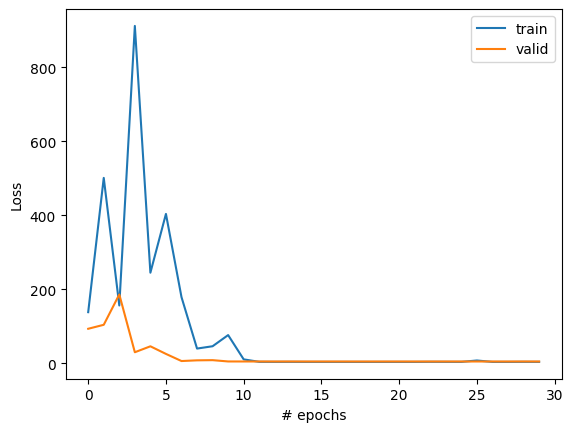

In [69]:
epochs = np.arange(num_epochs)
plt.plot(epochs, train_list, label='train')
plt.plot(epochs, valid_list, label='valid')
plt.xlabel("# epochs"), plt.ylabel("Loss"), plt.legend()
plt.show()

# Plot scatter label vs prediction

In [82]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        # Extract Parameters
        Pn = inputs[:, ::2]  # Even indices
        In = inputs[:, 1::2]  # Odd indices
        predicted_prior = outputs * Pn
        # Append predictions and targets for later plotting
        all_preds.append(predicted_prior.cpu().numpy())
        all_targets.append(targets.cpu().numpy())



# Convert lists to arrays
all_preds = np.concatenate(all_preds, axis=0).flatten()
all_targets = np.concatenate(all_targets, axis=0).flatten()


jump = 600
plt.figure(figsize=(10, 6))
plt.scatter(all_targets[0:len(all_preds):jump], all_preds[0:len(all_preds):jump], label='Predictions', color='blue', marker='o', alpha=0.6)
plt.scatter(all_targets[0:len(all_preds):jump], all_targets[0:len(all_preds):jump], label='Actual Labels', color='orange', marker='x', alpha=0.6)
plt.xlabel('Sample Number')
plt.ylabel('Value')
plt.title('Model Predictions vs. Actual Labels on Validation Set')
plt.legend()
plt.show()

RuntimeError: The size of tensor a (2) must match the size of tensor b (50) at non-singleton dimension 1

# Save weights

In [50]:
PATH = './Wireless_Net_poly(alpha).pth'
torch.save(model.state_dict(), PATH)
print("Finsh")

Finsh
